In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We use NHS prevalance data on a Clinical Commissioning Group (CCG) level and the Health scores of the 2015 IMD to predict the health scores of the 2019 IMD.

## 1. Load data

### 1.1 NHS Digital Quality and Outcomes Framework data

[Source](https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/quality-and-outcomes-framework-qof-2016-17)

The NHS QOF data contains prevalencies of various disease groups (indicators) at a GP level. They also providethe aggregate data on a CCG level. We use the latter. 

Specify which indicators to use for the regression. AF = Atrial Filibration, DEP = Depression, etc.

In [2]:
# Skip BP and SMOK as they don't have prevalences
indicators = ['AF', 'CHD', 'CVD-PP', 'HF', 'HYP', 'PAD', 'STIA', 'AST', 'COPD', 'OB', 'CAN', 'CKD', 'DM', 'PC', 'DEM', 'DEP', 'EP', 'LD', 'MH', 'OST', 'RA']

Load the 2014-2015 data

In [3]:
QOF_1415_AF = pd.read_excel('HFDI_data/qof-1415-ccg-all.xlsx', skiprows=12, header=[0, 1, 2], sheet_name='AF')
CCG_pop13 = QOF_1415_AF['Prevalence']['2013-14']['List Size']
CCG_pop14 = QOF_1415_AF['Prevalence']['2014-15']['List Size']
CCG_codes13 = QOF_1415_AF['Unnamed: 10_level_0']['Unnamed: 10_level_1']['CCG Geography Code']
CCG_codes14 = QOF_1415_AF['Unnamed: 10_level_0']['Unnamed: 10_level_1']['CCG Geography Code']

afflicted13_data = {
    'CCG Code' : CCG_codes13,
    'Population' : CCG_pop13,
}
afflicted14_data = {
    'CCG Code' : CCG_codes14,
    'Population' : CCG_pop14,
}
prevalence13_data = {
    'CCG Code' : CCG_codes13,
    'Population' : CCG_pop13,
}
prevalence14_data = {
    'CCG Code' : CCG_codes14,
    'Population' : CCG_pop14,
}

for indicator in indicators:
    df = pd.read_excel('HFDI_data/qof-1415-ccg-all.xlsx', skiprows=12, header=[0, 1, 2], sheet_name=indicator)

    afflicted13_data[indicator] = df['Prevalence']['2013-14']['Register']
    afflicted14_data[indicator] = df['Prevalence']['2014-15']['Register']
    
    prevalence13_data[indicator] = df['Prevalence']['2013-14']['Prevalence\n(per cent)']
    prevalence14_data[indicator] = df['Prevalence']['2014-15']['Prevalence\n(per cent)']
    
afflicted13 = pd.DataFrame(afflicted13_data)
afflicted14 = pd.DataFrame(afflicted14_data)
prevalence13 = pd.DataFrame(prevalence13_data)
prevalence14 = pd.DataFrame(prevalence14_data)

Load the 2019-20 data

In [4]:
year='2019-20'
data_path = 'HFDI_data/qof-1920-prev-ach-pca-ccg.xlsx'

QOF_1920_AF = pd.read_excel(data_path, skiprows=10, header=[0, 1, 3], sheet_name='AF')
QOF_1920_AF = QOF_1920_AF.loc[:134,:]
CCG_pop = QOF_1920_AF['_'][year]['List size']
CCG_codes = QOF_1920_AF['Unnamed: 1_level_0']['Return to Contents']['CCG ONS code (practice parent)']

afflicted_data = {
    'CCG Code' : CCG_codes,
    'Population' : CCG_pop,
}
prevalence_data = {
    'CCG Code' : CCG_codes,
    'Population' : CCG_pop,
}

for indicator in indicators:
    df = pd.read_excel(data_path, skiprows=10, header=[0, 1, 3], sheet_name=indicator)
    df = df.loc[:134,:]

    afflicted_data[indicator] = df['_'][year]['Register']
    prevalence_data[indicator] = df['_'][year]['Prevalence (%)']
    
afflicted19 = pd.DataFrame(afflicted_data)
prevalence19 = pd.DataFrame(prevalence_data)

### 1.2 IMD Health scores

Load the 2015 and 2019 Health scores, averaged on a CCG level.

In [5]:
df_IMD15_health = pd.read_excel('IMD_data/IMD_CCG_2015.xlsx', sheet_name='Health')
IMD15_health = df_IMD15_health[ ['Clinical Commissioning Group Code (2015)', 'Health Deprivation and Disability - Average score'] ]

df_IMD19_health = pd.read_excel('IMD_data/IMD_CCG_2019.xlsx', sheet_name='Health')
IMD19_health = df_IMD19_health[ ['Clinical Commissioning Group Code (2019)', 'Health Deprivation and Disability - Average score'] ]

## 2. Predict the 2015 IMD using a subset of the data

As a first exercise we do regression just within the 2015 data. We split the 2015 data into training and test subsets, and do regression on the former.

In [6]:
# Ensure that we only use CCG rows that both the IMD and the QOF share in common

valid_CCG = set(prevalence13['CCG Code'])
valid_CCG = list(valid_CCG.intersection( IMD15_health['Clinical Commissioning Group Code (2015)'] ))

_IMD15_health = IMD15_health[IMD15_health['Clinical Commissioning Group Code (2015)'].isin(valid_CCG)]
_prevalence13 = prevalence13[prevalence13['CCG Code'].isin(valid_CCG)];

_IMD15_health = _IMD15_health.sort_values(by='Clinical Commissioning Group Code (2015)')
_prevalence13 = _prevalence13.sort_values(by='CCG Code')

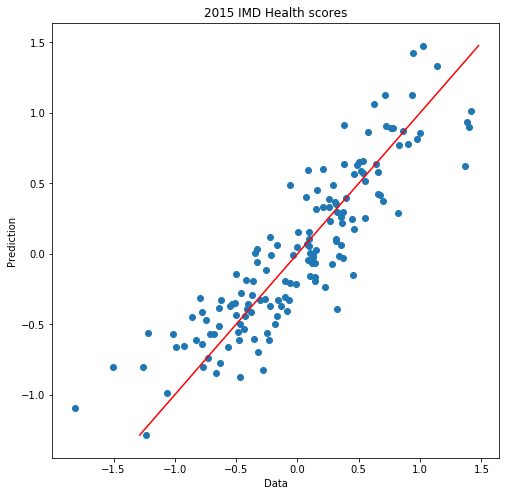

In [61]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

y = _IMD15_health.iloc[:,1]
X = np.array(_prevalence13.loc[:, 'AF':])

p_train = 0.3
train_mask = np.random.choice([True, False], X.shape[0], replace=True, p=[p_train, 1-p_train])
X_train = X[train_mask,:]
X_test = X[~train_mask,:]
y_train = y[train_mask]
y_test = y[~train_mask]

degree=1

polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

polyreg.fit(X_train,y_train)

y_pred = polyreg.predict(X_test)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.sort(y_pred), np.sort(y_pred), 'red')
ax.scatter(y_test, y_pred)
ax.set_xlabel('Data')
ax.set_ylabel('Prediction')
ax.set_title('2015 IMD Health scores')
plt.show()

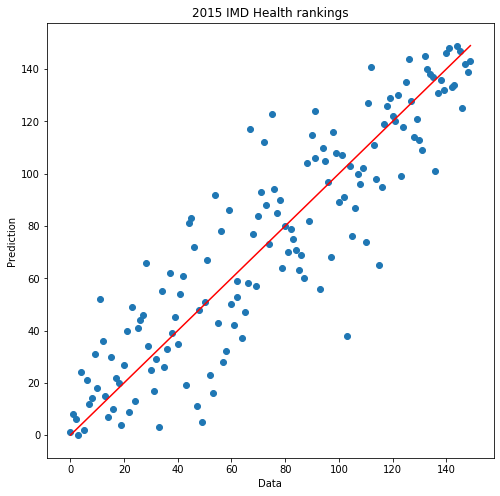

In [69]:
sorted_y_pred = np.sort(y_pred)

y_pred_ranking = []

for y in y_pred:
    y_pred_ranking.append(np.where(sorted_y_pred == y)[0][0])
    
    
sorted_y_test= np.sort(y_test)

y_test_ranking = []

for y in y_test:
    y_test_ranking.append(np.where(sorted_y_test == y)[0][0])
    
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.sort(y_pred_ranking), np.sort(y_pred_ranking), 'red')
ax.scatter(y_test_ranking, y_pred_ranking)
ax.set_xlabel('Data')
ax.set_ylabel('Prediction')
ax.set_title('2015 IMD Health rankings')


plt.show()

## 3. Predict the 2019 IMD from regression trained on 2015 IMD

Fit the regression model on the 2015 IMD and QOF data

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

y = _IMD15_health.iloc[:,1]
X = _prevalence13.loc[:, 'AF':]

degree=1

polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

polyreg.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [17]:
# Ensure that we only use CCG rows that both the IMD and the QOF share in common

valid_CCG = set(prevalence19['CCG Code'])
valid_CCG = list(valid_CCG.intersection( IMD19_health['Clinical Commissioning Group Code (2019)'] ))

_IMD19_health = IMD19_health[IMD19_health['Clinical Commissioning Group Code (2019)'].isin(valid_CCG)]
_prevalence19 = prevalence19[prevalence19['CCG Code'].isin(valid_CCG)];

_IMD19_health = _IMD19_health.sort_values(by='Clinical Commissioning Group Code (2019)')
_prevalence19 = _prevalence19.sort_values(by='CCG Code')

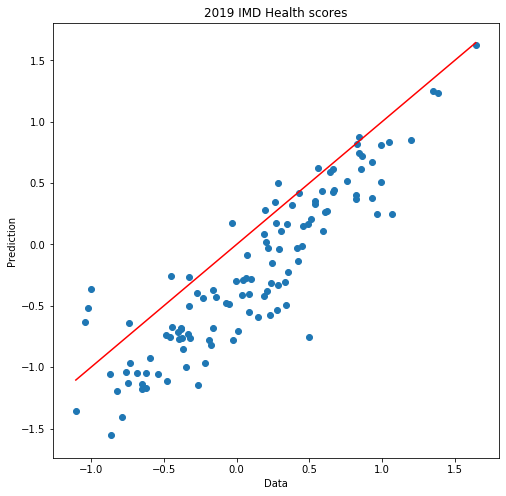

In [18]:
y19 = _IMD19_health.iloc[:,1]
X19 = _prevalence19.loc[:, 'AF':]

y_pred19 = polyreg.predict(X19)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.sort(y19), np.sort(y19), 'red')
ax.scatter(y19, y_pred19)
ax.set_xlabel('Data')
ax.set_ylabel('Prediction')
ax.set_title('2019 IMD Health scores')
plt.show()

## 4. Comparing IMD15 to IMD19

In [42]:
vals_15 = []
vals_19 = []
pred_19 = []

LSOA_to_IMD15 = {}

_IMD19_health = _IMD19_health.reset_index(drop=True)

for i, row in _IMD15_health.iterrows():
    LSOA_to_IMD15[row['Clinical Commissioning Group Code (2015)']] = row['Health Deprivation and Disability - Average score']

for i, row in _IMD19_health.iterrows():
    CCG_code = row['Clinical Commissioning Group Code (2019)']
    if CCG_code in LSOA_to_IMD15:
        vals_15.append(LSOA_to_IMD15[CCG_code])
        vals_19.append(row['Health Deprivation and Disability - Average score'])
        pred_19.append(y_pred19[i])

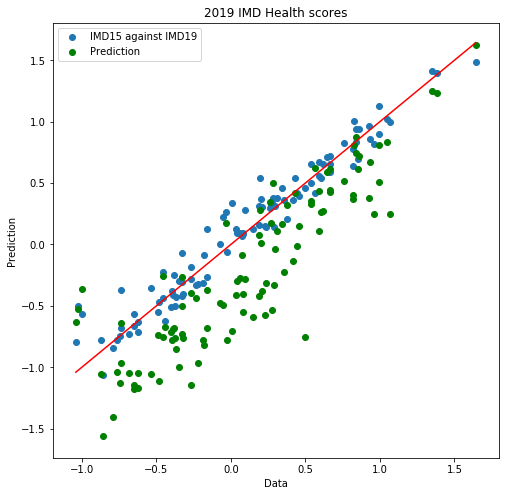

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(vals_19, vals_15, label='IMD15 against IMD19')
ax.scatter(vals_19, pred_19, color='green', label='Prediction')
ax.plot(np.sort(vals_19), np.sort(vals_19), 'red')
ax.set_xlabel('Data')
ax.set_ylabel('Prediction')
ax.set_title('2019 IMD Health scores')
plt.legend()
plt.show()